In [1]:
import cv2 as cv
import os
import IPython.display as ipd

import json

import numpy as np

import keras

from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Imports for face alignment
# pip install imutils
# conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [3]:
# DLIB Face detector for alignment
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

Good models:

- 8, more or less
- 13
- 14

In [4]:
# load keras model
model_number = 17
model = keras.models.load_model(f"./models/{model_number}_model.h5")

In [5]:
with open(f"models/{model_number}_model.json") as jf:
    json_file = json.load(jf)

In [6]:
json_file

{'mask': True,
 'model_n': 17,
 'featurewise_center': False,
 'featurewise_std': False,
 'class_indices': ['alinda', 'cami', 'gian', 'khaled', 'mamma', 'papi']}

In [7]:
# I didn't save the "class_indicices" field for some models...
if "class_indices" not in json_file:
    if model.output_shape[1] == 8:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi", "umbe"])
        
    if model.output_shape[1] == 7:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi"])
    if model.output_shape[1] == 6:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "mamma", "papi"])
    if model.output_shape[1] == 5:
        labels = np.array(["alinda", "cami",  "gian",
                           "mamma",  "papi",])
else:
    labels = np.array(json_file["class_indices"])

In [8]:
labels

array(['alinda', 'cami', 'gian', 'khaled', 'mamma', 'papi'], dtype='<U6')

# Test with webcam

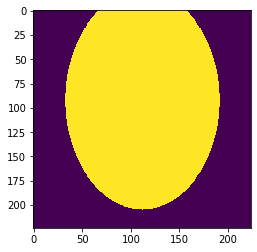

In [9]:
#TODO: Maybe define a function "create_mask" with the following default values
# and put it in utils_2d.py when cleaning code

a, b = 92, 112 # center of the ellipsis
n = 224 # the mask will b n*n
r = 112

y,x = np.ogrid[-a:n-a, -b:n-b]

mask = x*x + y*y/2 <= r*r/2

plt.imshow(mask)
plt.show()

In [10]:
def test_model(model, labels, mask, model_number = model_number,
               basedir = "test_pictures", new_width=200, mirror=True, more_space=10):
    
    file_format = "png"
    
    if not os.path.isdir(basedir):
        print(f"Created new directory {basedir}")
        os.makedirs(basedir)

    current_images = [img for img in os.listdir(basedir) if (img.endswith(file_format) and img.startswith(str(model_number)))]
    if len(current_images) == 0:
        latest_picture = -1
    else:
        latest_picture = max([int(current_images[i].split(".")[0].split("_")[1]) for i in range(len(current_images))])
    
    filename_format = f"{basedir}/{model_number}_"+"{}"+f".{file_format}"
    
    i = latest_picture
    
    labels = np.array(labels)
    cap = cv.VideoCapture(0)
    while(True):
        
        r, frame = cap.read()
        if mirror:
            frame = cv.flip(frame, 1)
        
        try:
            frame = add_box(frame, model, labels, mask, new_width, more_space)
            cv.imshow('Video', frame)
            
        except Exception as e:
            print(e)
            pass
    
        if cv.waitKey(1) & 0xFF == ord('s'):
            
            i += 1
            filename = filename_format.format(i)
            cv.imwrite(filename, frame)
            ipd.clear_output(wait=True)
            print(f"Saved {filename}".replace("//", "/"))
                
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
                        
    cap.release()
    cv.destroyAllWindows()

In [11]:
def add_box(img, model, labels, mask, new_width=200, more_space=10):
    m = more_space
    
    fontColors = [(0,0,255), (255,160,0), (0,255,0),
                  (0,255, 255), (193,182,255)]
    fontScale              = 2
    lineType               = 2
    font                   = cv.FONT_HERSHEY_PLAIN
    
    if img is not None:
        
        face = 0
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        og_width = gray.shape[1]
        scaler = og_width/new_width
        gray = imutils.resize(gray, width = new_width)

        faces = detector(gray, 2) # check: what is the 2
        
        for rect in faces:
            (x, y, w, h) = rect_to_bb(rect)
            # if align:
            gray2 = fa.align(gray, gray, rect)
            # else:
                # gray2 = gray[(y-m):(y+h+m), (x-m):(x+w+m)]
                # gray2 = cv.resize(gray, (224, 224))

            gray2 = cv.equalizeHist(gray2)
            gray2[~mask] = 0
            gray2 = gray2/255
            
            (x, y, w, h) = (np.array((x,y,w,h))*scaler).astype(int)
                
            pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
            text = labels[np.argmax(pred)]
            conf = pred[np.argmax(pred)]
                
            topLeftCornerOfText = (x-m,y-m-5)
            bottomLeftCornerOfText = (x-m,y+h+35)    
            fontColor              = fontColors[face]
            face += 1
                  
            cv.rectangle(img,(x-m,y-m),(x+w+m,y+h+m),fontColor,2)
            cv.putText(img, f"{text}", topLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
            cv.putText(img, f"{conf:.2f}", bottomLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
                    
    return img

`new_width` is the width of the resized image passed to the dlib detector.

Smaller values mean smoother webcam preview, but prediction is slightly affected.

OK values are between 150/250 depending on how far the face is from the webcam

In [21]:
# spam q to exit, the save function makes exiting lag a bit
test_model(model,labels, mask, new_width=200)

Saved test_pictures/17_94.png


## Test single shot

In [13]:
def test_model_single_shot(model,labels, mask, new_width=200, mirror = True):
    
    cap = cv.VideoCapture(0)
    result, img = cap.read()
    
    if mirror:
            img = cv.flip(img, 1)
    
    cap.release()
    
    img2 = add_box(img, model, labels, mask, new_width)[:,:,::-1]
    
    plt.figure(figsize=(14,7))
    plt.imshow(img2)
    plt.show()
    
    return img2

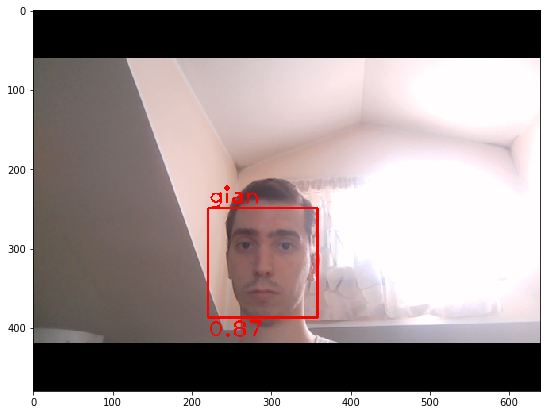

In [15]:
img = test_model_single_shot(model, labels, mask)

# Test Directories

In [16]:
labels

array(['alinda', 'cami', 'gian', 'khaled', 'mamma', 'papi'], dtype='<U6')

In [17]:
def test_directory(name, basedir, labels, new_width=200):
    # might make sense to test on some pictures not used during training
    
    srcdir = basedir+"/"+name
    counts={}
    for label in labels:
        counts[label] = 0
    total = 1
    
    for file in os.listdir(srcdir):
        img = cv.imread(srcdir+"/"+file)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = imutils.resize(gray, new_width)
        faces = detector(gray, 2)
        if len(faces)>0:
            rect = faces[0]
            gray2 = fa.align(gray, gray, rect)
        else:
            gray2 = cv.resize(gray, (224, 224))
        gray2 = cv.equalizeHist(gray2)
        gray2[~mask] = 0
        gray2 = gray2/255
        
        pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
        text = labels[np.argmax(pred)]
        
        counts[text] += 1
        ipd.clear_output(wait=True)
        for i in counts.keys():
            print("{}: {}".format(i, counts[i]))
        print("\ntotal: ", total)
        print("accuracy: ", counts[name]/total)
        total += 1

This also gives an idea of the difference in speed and accuracy when resizing the picture before detecting the face with dlib.

(Note that the following is resizing a picture that is already cropped and with a face, while in the above tests it is resizing the picture from the webcam).

(most folders in "picture_new" also contain images not used during training)

In [18]:
%%time
test_directory("alinda", "pictures_new", labels, new_width=10)

alinda: 398
cami: 9
gian: 117
khaled: 0
mamma: 0
papi: 0

total:  524
accuracy:  0.7595419847328244
Wall time: 22.6 s


In [19]:
%%time
test_directory("alinda", "pictures_new", labels, new_width=50)

alinda: 495
cami: 3
gian: 19
khaled: 0
mamma: 0
papi: 7

total:  524
accuracy:  0.9446564885496184
Wall time: 30.7 s


In [20]:
%%time
test_directory("alinda", "pictures_new", labels, new_width=100)

alinda: 512
cami: 1
gian: 8
khaled: 0
mamma: 0
papi: 3

total:  524
accuracy:  0.9770992366412213
Wall time: 50.7 s


# TODO:

- Add `threshold` parameter to add_box function: under a certain threshold, don't give a prediction.